In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [10]:
df = pd.read_parquet("target1_data.parquet")

In [12]:
target_col = "target_new" if "target_new" in df.columns else "target"

print(f" Veri Seti Başarıyla Yüklendi.")
print(f"   - Satır Sayısı: {df.shape[0]}")
print(f"   - Özellik Sayısı: {df.shape[1]}")
print(f"   - Hedef Değişken: '{target_col}'")

print("\nSınıf Dağılımı (%):")
print(df[target_col].value_counts(normalize=True).sort_index())

 Veri Seti Başarıyla Yüklendi.
   - Satır Sayısı: 61432
   - Özellik Sayısı: 41
   - Hedef Değişken: 'target_new'

Sınıf Dağılımı (%):
target_new
0    0.335021
1    0.324977
2    0.340002
Name: proportion, dtype: float64


In [14]:
# Veri Ayrıştırma (Train-Test Split)

X = df.drop(columns=[target_col])
y = df[target_col]

# %80 Eğitim, %20 Test olarak ayırıyoruz.
# stratify=y -> Sınıf oranlarını (Low/Medium/High) her iki sette de korur.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Veri Ayrıştırıldı:")
print(f"   - Eğitim Seti: {X_train.shape}")
print(f"   - Test Seti  : {X_test.shape}")

Veri Ayrıştırıldı:
   - Eğitim Seti: (49145, 40)
   - Test Seti  : (12287, 40)


In [16]:
# Model Eğitimi ve Optimizasyon (GridSearch)

# Denenecek parametre uzayı
param_grid = {
    'n_estimators': [100, 200],       # Ağaç sayısı
    'max_depth': [10, 20, None],      # Ağaç derinliği (Overfitting önlemek için)
    'min_samples_split': [2, 5]       # Dallanma için gereken minimum örnek
}

# Modeli tanımlayalım
rf_base = RandomForestClassifier(random_state=42)

# 5-Katlı Çapraz Doğrulama ile en iyi parametreyi arıyoruz
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                
    n_jobs=-1,           
    verbose=2,           
    scoring='accuracy'   
)

print("Hiperparametre araması başladı...")
grid_search.fit(X_train, y_train)

print(f"\nEn İyi Parametreler: {grid_search.best_params_}")
print(f"En İyi Cross-Val Skoru: {grid_search.best_score_:.4f}")

# En iyi modeli seçip devam ediyoruz
best_rf_model = grid_search.best_estimator_

Hiperparametre araması başladı...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   6.0s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   6.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   6.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   6.0s
[CV] END max_depth=10, min_s


TEST SONUÇLARI
Doğruluk (Accuracy): 0.8609
F1 Skoru (Weighted): 0.8609

Detaylı Sınıflandırma Raporu:

              precision    recall  f1-score   support

           0      0.857     0.924     0.889      4116
           1      0.789     0.780     0.785      3993
           2      0.938     0.876     0.906      4178

    accuracy                          0.861     12287
   macro avg      0.861     0.860     0.860     12287
weighted avg      0.862     0.861     0.861     12287



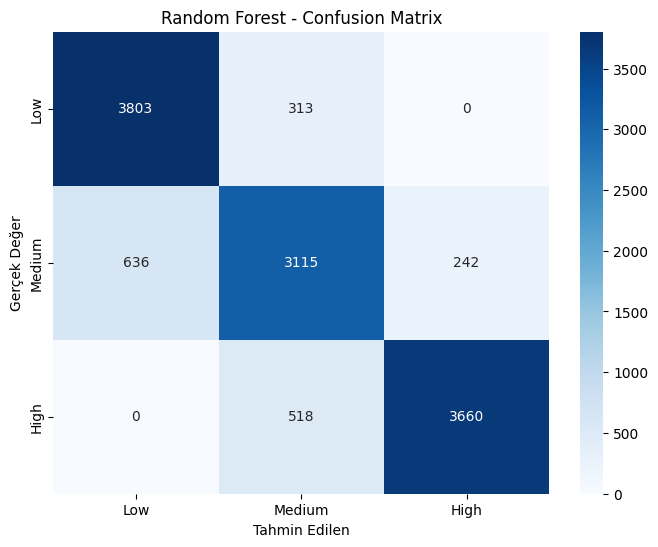

In [17]:
# Model Performans Analizi

y_pred = best_rf_model.predict(X_test)

# Metrikleri hesaplama
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*40)
print(f"TEST SONUÇLARI")
print("="*40)
print(f"Doğruluk (Accuracy): {acc:.4f}")
print(f"F1 Skoru (Weighted): {f1:.4f}")
print("\nDetaylı Sınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred, digits=3))

# Karmaşıklık Matrisi Görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'], 
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.title('Random Forest - Confusion Matrix')
plt.show()

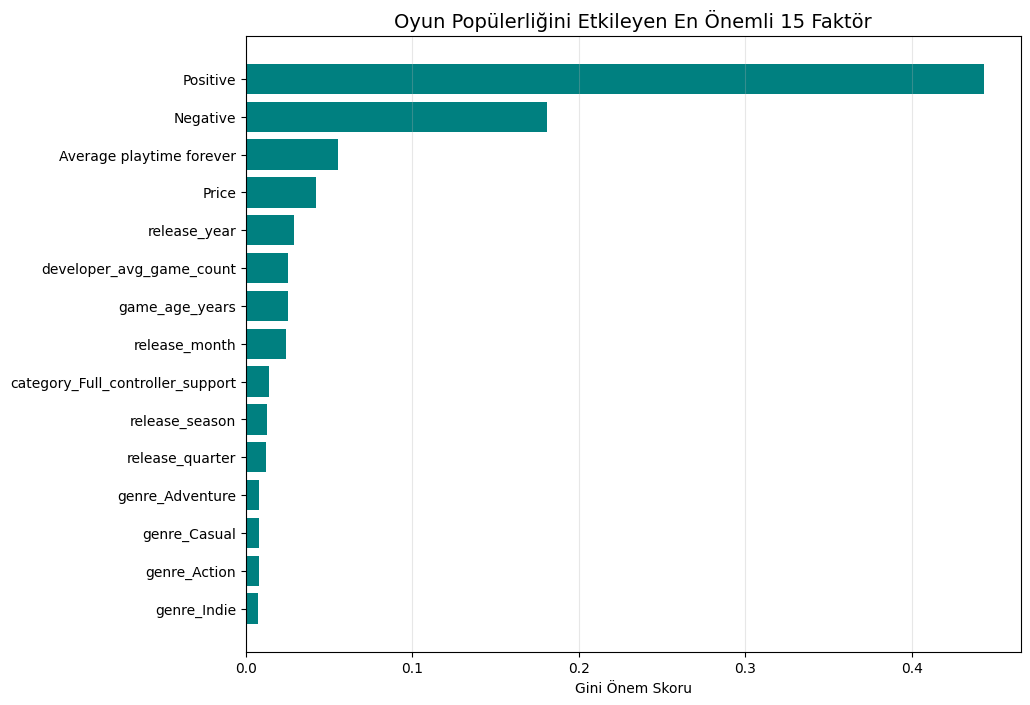

In [ ]:
# Özellik Önem Düzeyleri

importances = best_rf_model.feature_importances_
feature_names = X.columns

# Önem düzeyine göre sıralama
indices = np.argsort(importances)[-15:]  # En önemli 15 özellik

plt.figure(figsize=(10, 8))
plt.title('Oyun Popülerliğini Etkileyen En Önemli 15 Faktör', fontsize=14)
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Gini Önem Skoru')
plt.grid(axis='x', alpha=0.3)
plt.show()